# Wind Speed Analysis for Wind Farm Potential in Ireland

The purpose of this project is to analyse historical wind data across Ireland to evaluate the suitability of locations for wind farms and to estimate their potential performance. 


This project focuses on:

1/ Getting historical wind speed data from meteorological stations

2/ Cleaning and normalising weather datasets

3/ Estimating wind power availability at different locations

4/ Identifying trends in wind speeds over time

5/ Exploring additional weather variables relevant to wind energy

6/ (Optional/Advanced) Estimating short-term wind power output using weather forecasts

## 1/ Historical weather data

Raw data are sourced from Met Éireann - [The Irish Meteorological Service](https://www.met.ie/climate/available-data/historical-data):

Hourly Historical Weather data of 22 stations are downloaded as ZIP files, then unzipped and uploaded into the folder 'project/data' on Github as CSV files, each file corresponding to a location where the wind data is recorded. 

The variables are different from location to location, but all the CSVs contain these variables:

- date: Date and time 

- rain: Precipitation Amount (mm)

- temp: Air Temperature (C)	

- wdsp: Mean Wind Speed (knot)

- wddir: Predominant Wind Direction (degree)


## 2/ Data cleaning and normalisation with the function 'file_with_station'

The function file_with_station is used to clean, normalise, and prepare raw hourly weather data for wind energy analysis. The raw datasets contain metadata rows, missing values, and non-standard units, which must be processed before analysis.

Data cleaning steps performed by the function include:

- Identifying the row where the data begin by locating the header containing “date”.

- Removing all rows above the header to eliminate metadata and descriptive text.

- Retaining only relevant variables (date, wdsp, temp, rain) needed for wind analysis.

- Converting wind speed (wdsp) values to numeric format.

- Removing all rows before the first valid wdsp, non-zero wind speed measurement to ensure data reliability.


Data normalisation steps include:

- Converting the 'date' column into a standard datetime format.

- Filling missing wind speed values using linear interpolation over time.

- Converting wind speed from knots to metres per second (m/s).

- Creating new columns for different time formats (day, month, year, etc.) to help analyse wind patterns.

- Adding a station name so data from different locations can be compared.

- Energy-related steps:

    Calculating air density from temperature using the ideal gas law.

    Estimating wind power from wind speed and air density, turning weather data into energy information.

The function saves the cleaned and organised data as a new CSV file named after the station into the folder 'stationdata', ready for analysis and visualisation.

References: Wind power calculation
https://en.wikipedia.org/wiki/Wind_power

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [ ]:
def file_with_station(file,station):

    # -------- Delete uneccessary rows ------------------------------
    # Read file as text
    with open(file, "r", encoding="utf-8") as f:
        lines = f.readlines()

    # Find the row number where the data starts i.e. the row that contain 'date' in its first column
    header_row = None

    for i, line in enumerate(lines):
        # split on comma and strip spaces
        first_cell = line.split(",")[0].strip().lower()
        if first_cell == "date":
            header_row = i
            break

    # Read file as csv, delete uneccessary rows
    df = pd.read_csv(file, skiprows=header_row,low_memory=False)


    # --------- Keep only useful columns ----------------------------- 
    df = df[["date", "wdsp", "temp", "rain"]]

    # convert 'wdsp' to numeric
    df["wdsp"] = pd.to_numeric(df["wdsp"], errors="coerce")

    # find first row where wind speed is not NaN
    first_valid_value = df.loc[(df["wdsp"].notna()) & (df["wdsp"] != 0)].index.min()

    # drop rows before that
    df = df.loc[first_valid_value:].reset_index(drop=True)


    # --------- Fill up missing value ----------------------------------
    # modify the format of 'date'
    df['date'] = pd.to_datetime(df['date'], format='%d-%b-%Y %H:%M')

    # Set 'date' as index as interpolate based on actual time differences between index values
    df = df.set_index('date')

    # Interpolate missing windspeed (linear is best for meteorological data) -- I use AI to help me with this.
    df['wdsp'] = df['wdsp'].interpolate(method='time', limit_direction='both', limit_area='inside')

    
    # --------- Add new columns ---------------------------------------
    # Bring 'date' back as a column
    df = df.reset_index()

    # Add a column that contains only date details
    df['dateonly']= df['date'].dt.date

    # Add a column that contains only year
    df['year'] = pd.to_datetime(df['date']).dt.strftime('%Y')

    # Add a column that contains only month-year
    df['yearmonth'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')

    # Add a column that contains only month
    df['month'] = pd.to_datetime(df['date']).dt.strftime('%m')

    # Add a column that contains only hour
    df['hour'] = pd.to_datetime(df['date']).dt.strftime('%H:%M')

    # convert the measurement of wdsp into m/s
    df["wdsp_ms"] = df["wdsp"] * 0.5144444444

    # Add a column which takes the station name as value
    df["station"]= station

    # convert 'temp' to numeric
    df["temp"] = pd.to_numeric(df["temp"], errors="coerce")
    R = 287.05       # J/(kg·K)
    p = 101325       # Pa (assumed constant)
    # Add column 'rho' - air density
    df["rho"] = p / (R * (df["temp"] + 273.15))

    # Add column 'power' - wind power density
    df['power'] = 0.5 * df["rho"] * df["wdsp_ms"]**3


    # --------- Save as a new file in folder stationdata ----------------
    df.to_csv(f"stationdata/{station}.csv", index=False)
    print(f"The file {station}.csv is now created.")

In [3]:
file_with_station("data/hly275.csv","MACE HEAD")
file_with_station("data/hly375.csv","OAK PARK")
file_with_station("data/hly518.csv","SHANNON AIRPORT")
file_with_station("data/hly532.csv","DUBLIN AIRPORT")
file_with_station("data/hly575.csv","MOORE PARK")
file_with_station("data/hly675.csv","BALLYHAISE")
file_with_station("data/hly775.csv","SHERKIN ISLAND")
file_with_station("data/hly875.csv","MULLINGAR")
file_with_station("data/hly1075.csv","ROCHES POINT")
file_with_station("data/hly1175.csv","NEWPORT")
file_with_station("data/hly1375.csv","DUNSANY")
file_with_station("data/hly1475.csv","GURTEEN")
file_with_station("data/hly1575.csv","MALIN HEAD")
file_with_station("data/hly1775.csv","JOHNSTOWN CASTLE 2")
file_with_station("data/hly1875.csv","ATHENRY")
file_with_station("data/hly1975.csv","MT DILLON")
file_with_station("data/hly2075.csv","FINNER")
file_with_station("data/hly2175.csv","CLAREMORRIS")
file_with_station("data/hly2275.csv","VALENTIA OBSERVATORY")
file_with_station("data/hly2375.csv","BELMULLET")
file_with_station("data/hly3904.csv","CORK AIRPORT")
file_with_station("data/hly4935.csv","KNOCK AIRPORT")

The file MACE HEAD.csv is now created.
The file OAK PARK.csv is now created.
The file SHANNON AIRPORT.csv is now created.
The file DUBLIN AIRPORT.csv is now created.
The file MOORE PARK.csv is now created.
The file BALLYHAISE.csv is now created.
The file SHERKIN ISLAND.csv is now created.
The file MULLINGAR.csv is now created.
The file ROCHES POINT.csv is now created.
The file NEWPORT.csv is now created.
The file DUNSANY.csv is now created.
The file GURTEEN.csv is now created.
The file MALIN HEAD.csv is now created.
The file JOHNSTOWN CASTLE 2.csv is now created.
The file ATHENRY.csv is now created.
The file MT DILLON.csv is now created.
The file FINNER.csv is now created.
The file CLAREMORRIS.csv is now created.
The file VALENTIA OBSERVATORY.csv is now created.
The file BELMULLET.csv is now created.
The file CORK AIRPORT.csv is now created.
The file KNOCK AIRPORT.csv is now created.


## 3/ Wind Power Potential Analysis

In this step, we use the cleaned station data to study wind speed and wind power over time. The goal is to see when and where wind energy is strongest, both daily and seasonally, and to compare the potential across different locations.

### The analysis:

- Calculates monthly average wind speed for each station to see seasonal trends.

- Calculates hourly average wind speed to examine daily patterns and identify peak wind hours.

- Calculates monthly average wind power density to understand seasonal energy availability.

- Calculates hourly average wind power density to study daily fluctuations in wind energy.

- Compares all stations on the same plots to highlight the best locations for wind energy potential. The resulting plots are saved in the 'plot' folder for reporting.

### Analysis of the results:

##### Monthly wind speed all stations

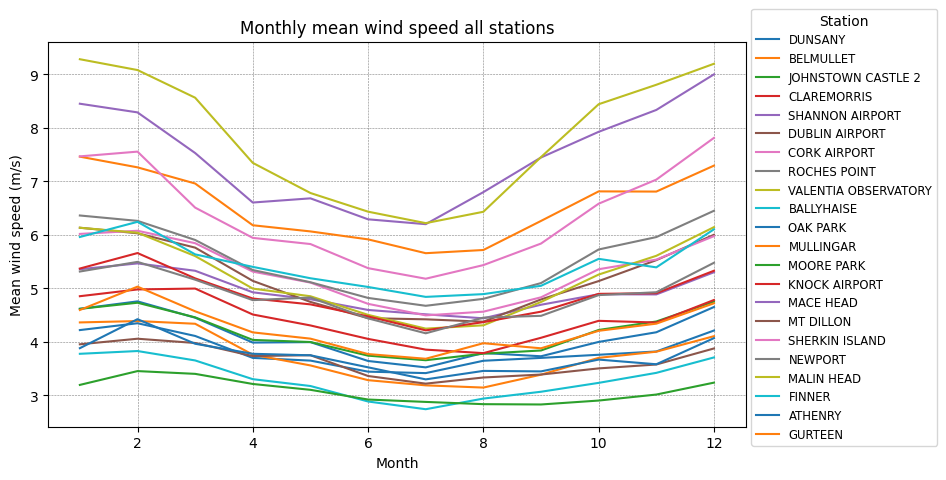

In [3]:
DATADIR = Path("stationdata")

plt.figure(figsize=(9, 5))
for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file,low_memory=False)

    # Mean wind speed monthly
    monthly_wdsp = df.groupby("month")["wdsp_ms"].mean()
    
    # Use the file name (without extension) as the label
    monthly_wdsp.plot(label=file.stem)

plt.xlabel("Month")
plt.ylabel("Mean wind speed (m/s)")
plt.title("Monthly mean wind speed all stations")
plt.legend(title="Station", fontsize='small',bbox_to_anchor=(1,1.1))
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)

# put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
plt.savefig(f"plot/Wind speed study - monthly mean windspeed.png")

plt.show()

This plot displays the long-term average monthly mean wind speed at 22 weather stations. 

All stations follow a very similar seasonal pattern. Strongest winds occur in the winter months (December–February), and the wind speed reaches the minimum in the summer months (June–August). 

The wind speed is highest and the seasonal variation is the greatest at Valentia Observatory, Belmullet, Malin Head, Mace Head, and Sherkin Island (western coastal and northern stations). Often the wind speed is 7-9+ m/s in winter and 5-6+ m/s in summer, which represents a difference of 1-2 m/s. 

The western/ midland stations like Shannon Airport, Roches Point, and Johnstown Castle represent moderate windspeed and moderate seasonal variation. 

The wind speed is lowest and the seasonal variation is low at Dunsany, Oak Park, Moore Park, Athenry, and Mullingar (inland and eastern stations), mostly 3-5 m/s year-round, with winter max wind speed rarely exceeding 5 m/s.

##### Hourly wind speed all stations

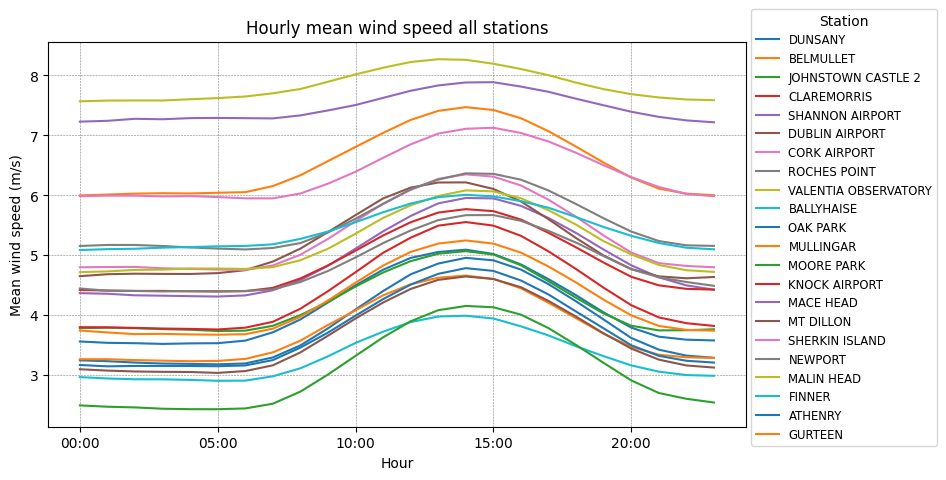

In [4]:
DATADIR = Path("stationdata")

plt.figure(figsize=(9, 5))
for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file,low_memory=False)
    
    # Mean wind speed monthly
    hourly_wdsp = df.groupby("hour")["wdsp_ms"].mean()
    
    # Use the file name (without extension) as the label
    hourly_wdsp.plot(label=file.stem)

plt.xlabel("Hour")
plt.ylabel("Mean wind speed (m/s)")
plt.title("Hourly mean wind speed all stations")
plt.legend(title="Station", fontsize='small',bbox_to_anchor=(1,1.1))
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)

# put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
plt.savefig(f"plot/Wind speed study - hourly mean windspeed.png")

plt.show()

This chart shows the typical 24-hour variation in mean wind speed for 22 stations.

The pattern is very consistent across the country: 
- Minimum wind speeds occur in the early morning hours (usually 3–7 am). 
- Maximum wind speeds occur in the mid-to-late afternoon (typically 2–4 pm).
- Wind speeds then steady decline through the evening and night.

The difference between daily min and max is generally 1–2.5 m/s: 
- largest (2-2.5 m/s) at exposed coastal and western stations; also, at these stations the peak is earlier than in other locations.
- moderate (1.2-1.8 m/s) at midland and eastern stations, 
- smallest (0.8-1.3 m/s) at most inland locations

##### Wind power density all stations

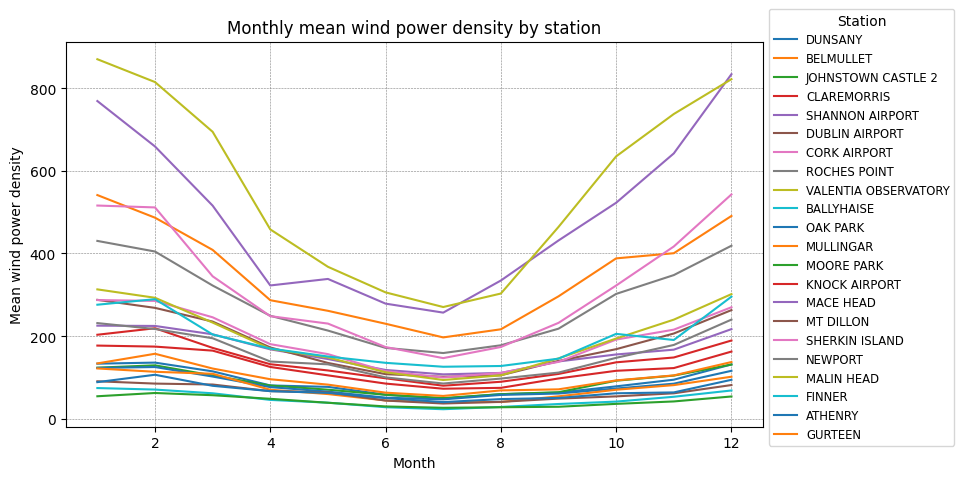

In [ ]:
DATADIR = Path("stationdata")

plt.figure(figsize=(9, 5))
for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file,low_memory=False)
    
    # Mean wind speed monthly
    monthly_power = df.groupby("month")["power"].mean()
    
    # Use the file name (without extension) as the label
    monthly_power.plot(label=file.stem)

plt.xlabel("Month")
plt.ylabel("Mean wind power density")
plt.title("Monthly mean wind power density all station")
plt.legend(title="Station", fontsize='small',bbox_to_anchor=(1,1.1))
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)

# put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
plt.savefig(f"plot/Wind density study - monthly mean wind power density.png")

plt.show()

This plot displays the long-term average monthly wind power density (W/m²) for 22 studied stations across Ireland.

Wind power density is proportional to the cube of wind speed (P x v³), so small differences in mean wind speed translate into very large differences in available power — this explains why the ranking and seasonal contrast appear dramatically amplified compared to the mean wind speed plot.

We observe here an extreme seasonal variation: Winter months (Dec–Feb) deliver 3–10 times more power density than summer months (Jun–Aug) at the best sites.

Constrast between locations:

- Exposed west coast → 700–850+ W/m² in winter vs. 200–350 W/m² in summer
- Inland/sheltered → 80–150 W/m² winter vs. 30–70 W/m² summer

##### Hourly wind power all stations

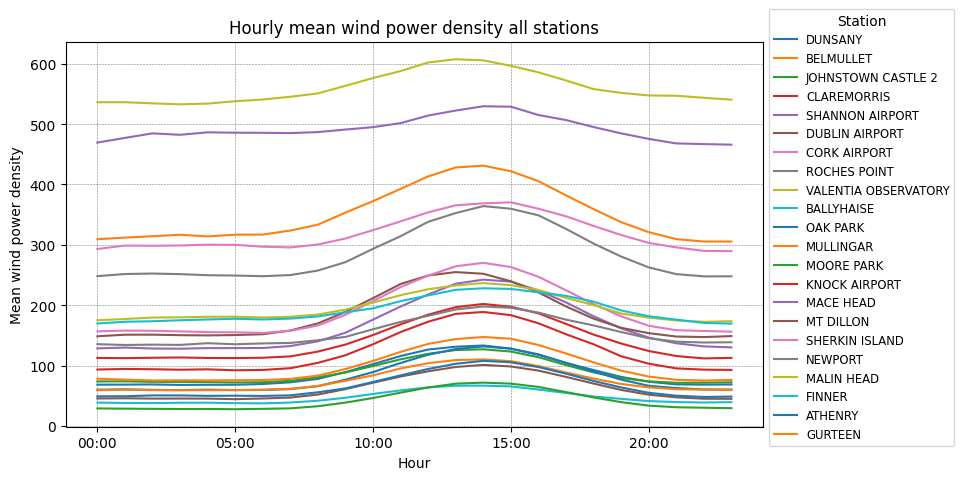

In [5]:
DATADIR = Path("stationdata")

plt.figure(figsize=(9, 5))
for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file,low_memory=False)
    
    # Mean wind speed monthly
    hourly_power = df.groupby("hour")["power"].mean()
    
    # Use the file name (without extension) as the label
    hourly_power.plot(label=file.stem)

plt.xlabel("Hour")
plt.ylabel("Mean wind power density")
plt.title("Hourly mean wind power density all stations")
plt.legend(title="Station", fontsize='small',bbox_to_anchor=(1,1.1))
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)

# put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
plt.savefig(f"plot/Wind density study - hourly mean wind power density.png")

plt.show()

The chart shows long-term average hourly wind power density in W/m² throughout the 24-hour day for all stations studied.

Because wind power density scales with the cube of wind speed (P x v³), the diurnal pattern is much more pronounced than in the mean wind speed plot — even modest increases in afternoon wind speed create large increases in available power.

Very strong 24-hour cycle is observed at all sites.
- Minimum power density: early morning (usually 04:00–07:00)
- Maximum power density: mid-afternoon (typically 13:00–16:00, peaking around 14:00–15:00)

Afternoon peak is 1.5–3.0 times higher than the early-morning minimum at most stations (far more extreme than the ~1.2–2.5× range seen in wind speed itself).

## 4/ Analysis of wind turbine operating hours


It’s not only the speed, but more importantly the consistency of wind that produces the most power. Wind turbines operate within specific speed ranges: 
- Cut-in speed: they start generating power around 3–4 m/s.
- Rated speed (Max Output): Around 12–14 m/s, where turbines generate their maximum power.
- Cut-out speed (Shutdown): Above 25 m/s to protect the turbine from severe wind damage.
- Optimal Range: Generally considered to be between 4 m/s and 12 m/s for efficient power generation, though turbines are designed to operate up to their cut-out speed.

The code below returns bar charts showing how many hours per year a wind turbine could operate, and how many of those hours are optimal for power production in multiple stations. Each CSV file produces one plot, saved as a PNG image.

Ref for plot: 
https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html



/tmp/ipykernel_2542/2263401133.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 3))


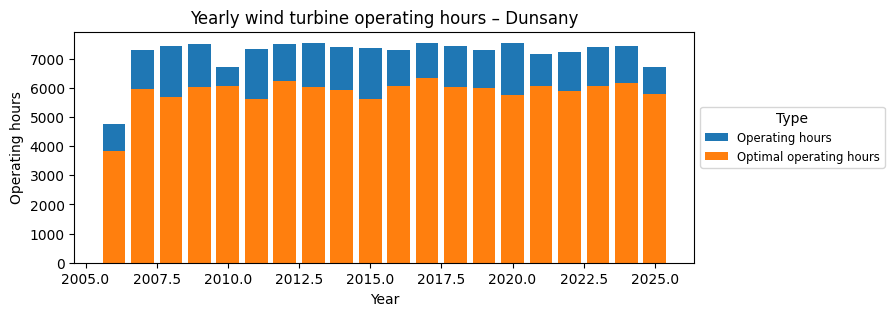

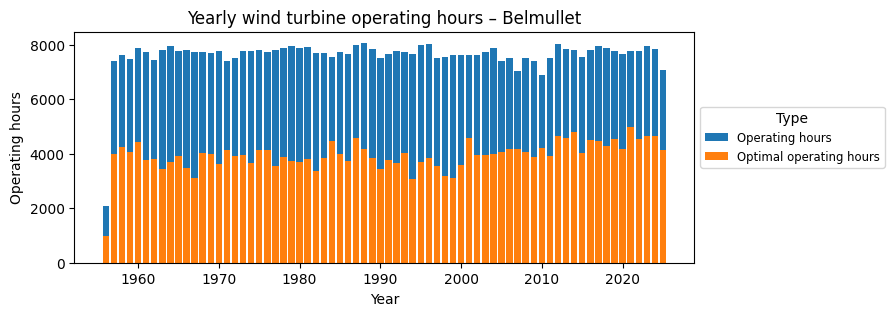

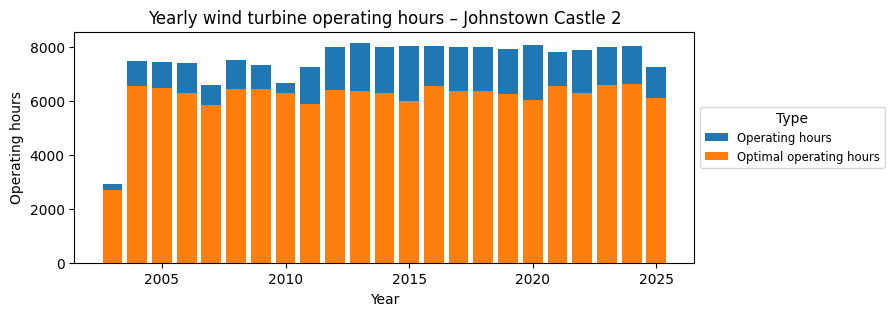

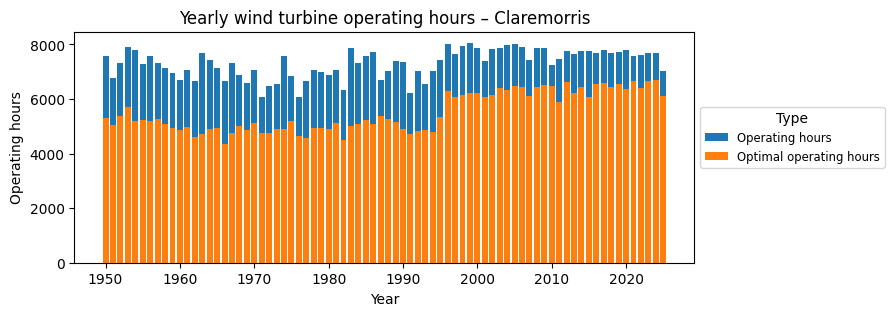

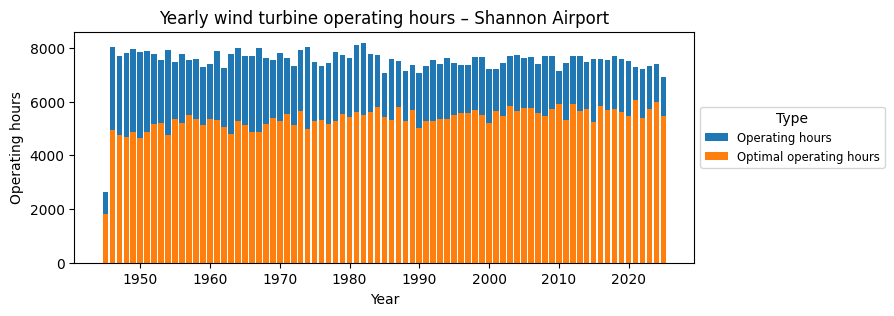

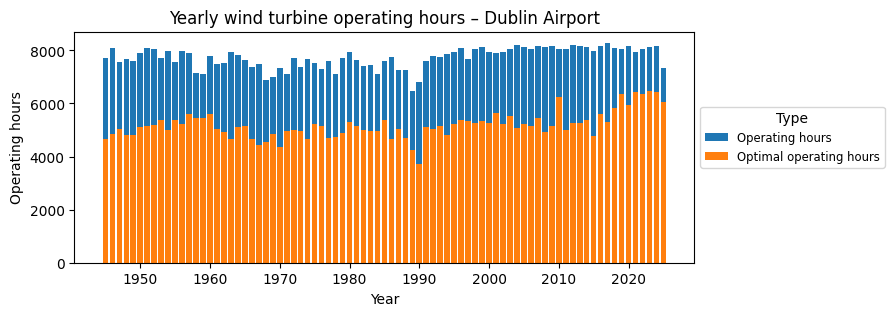

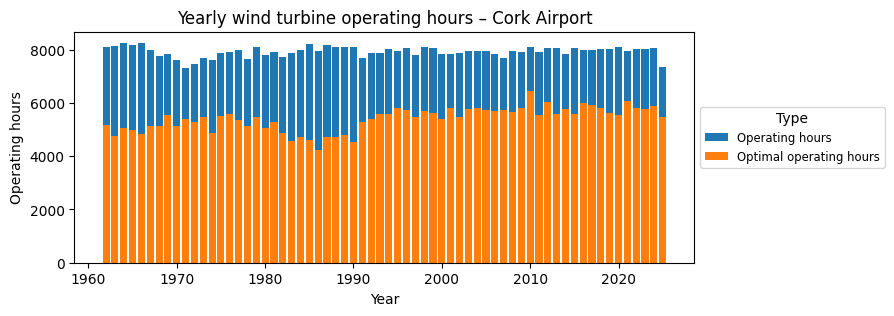

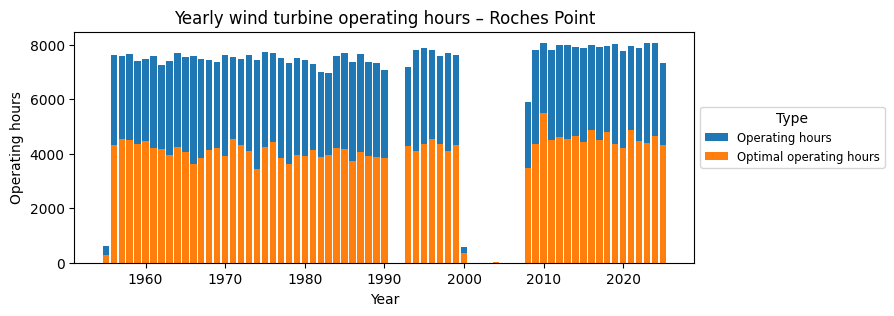

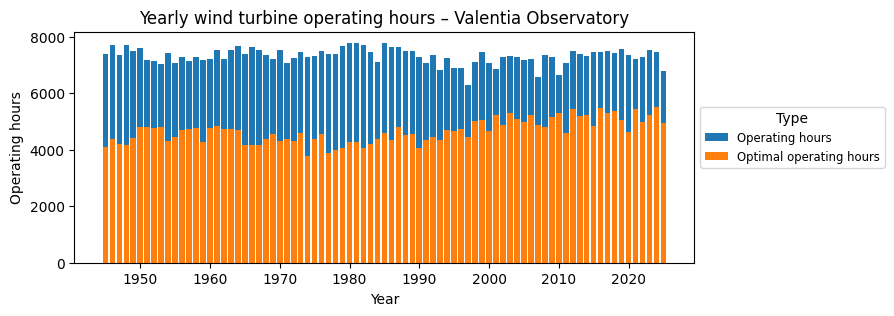

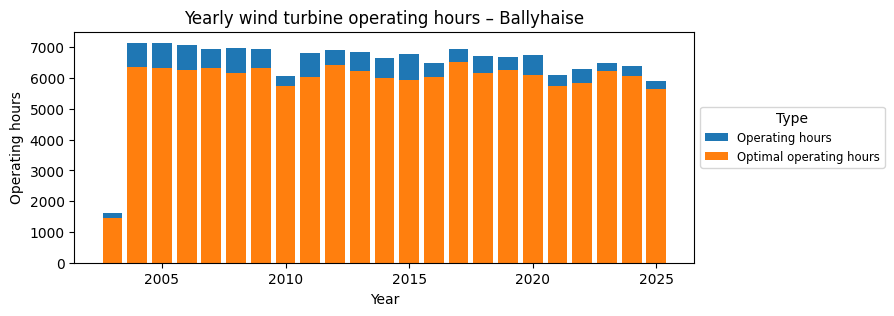

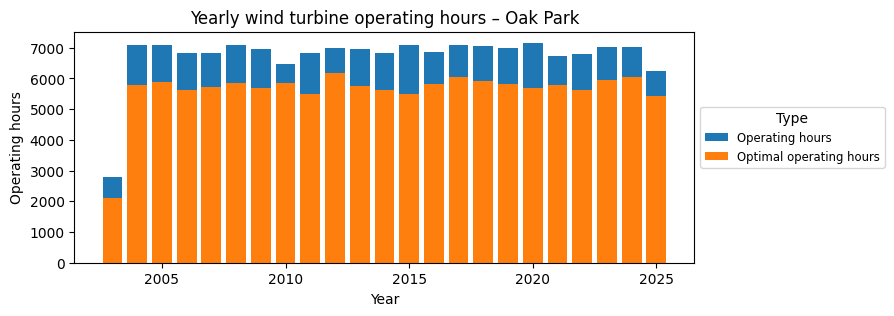

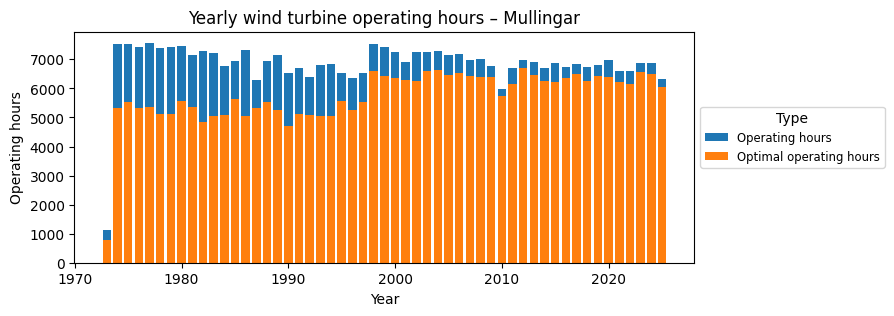

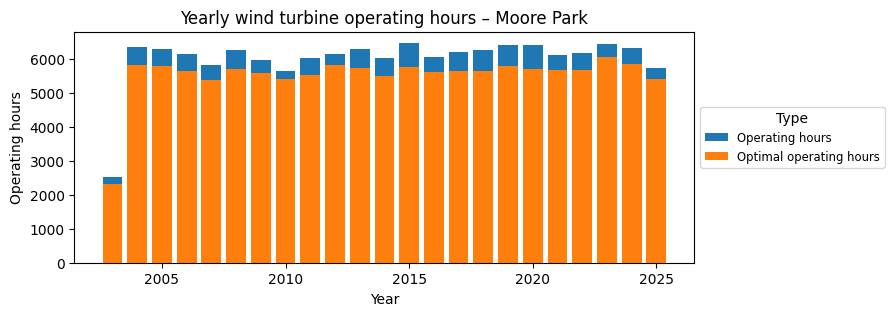

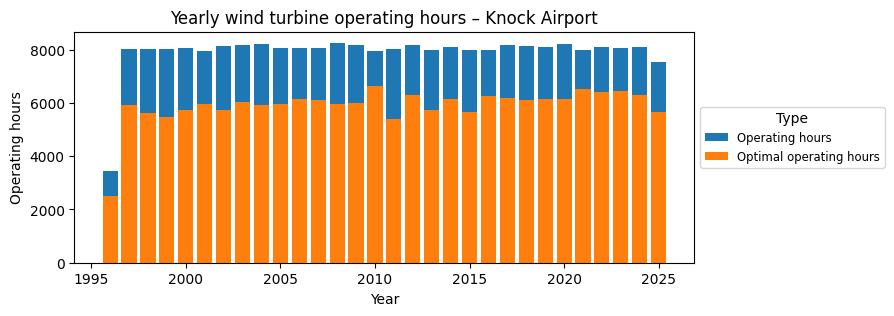

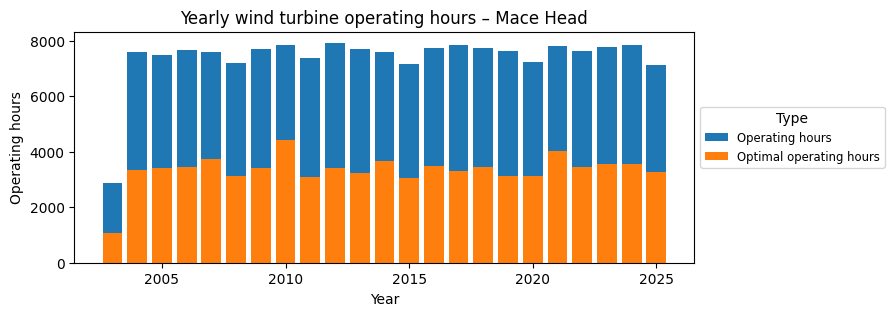

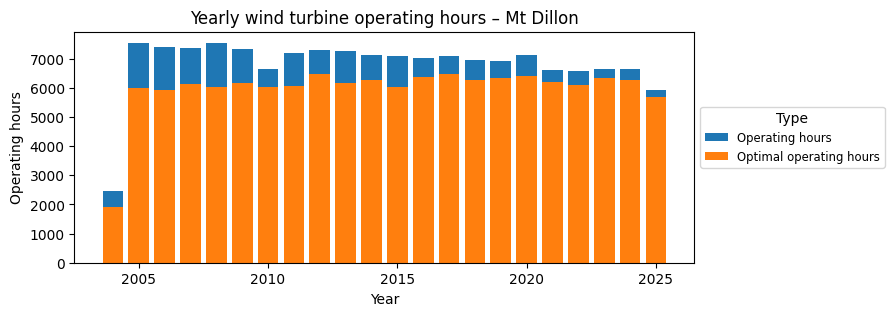

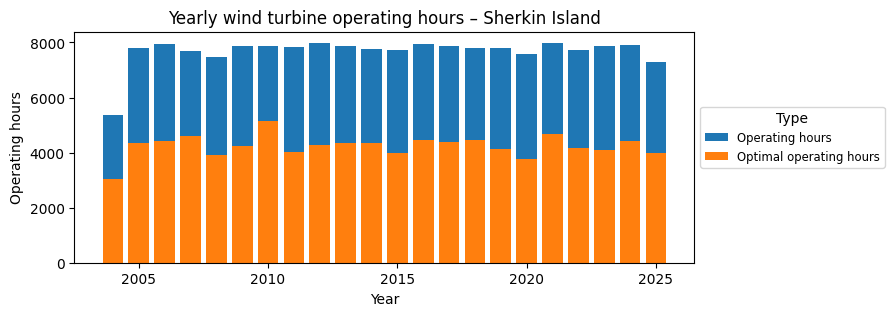

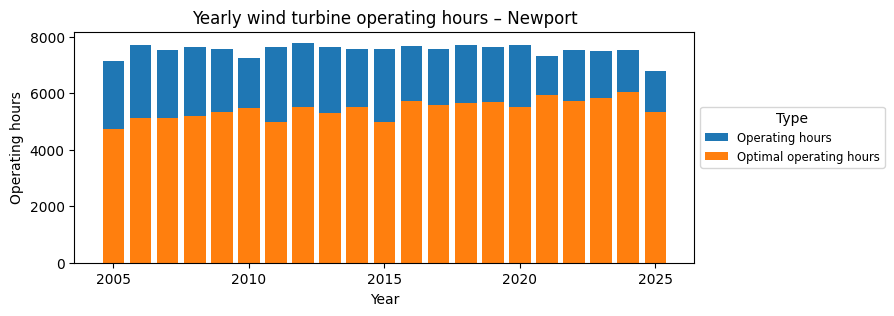

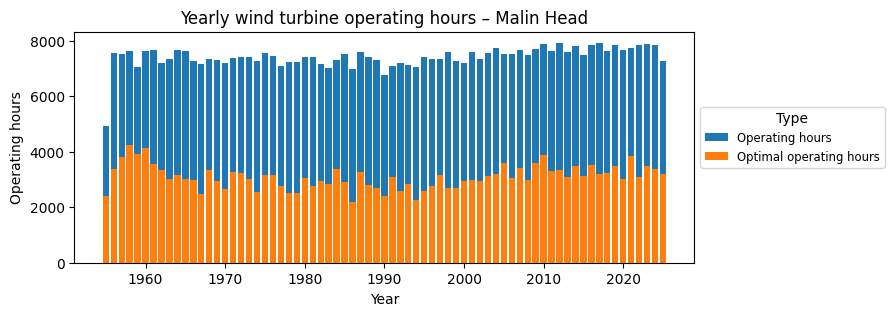

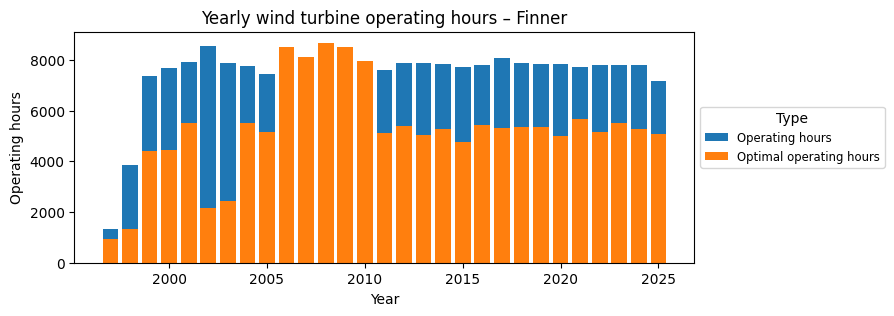

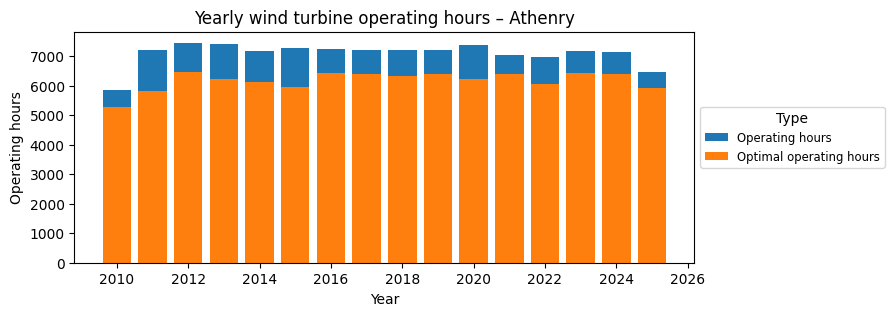

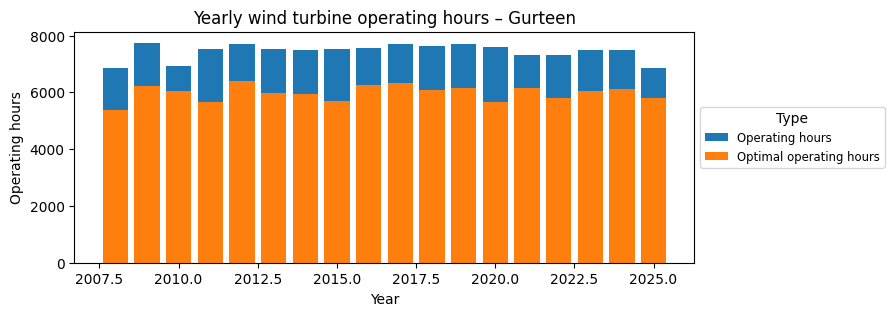

In [8]:
# Define the wind range
cut_in = 4
optimum = 12   
cut_out = 25

DATADIR = Path("stationdata")

for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file,low_memory=False)
    
    # Study wind range for wind turbines operation
    df["operating"] = (df["wdsp"] >= cut_in) & (df["wdsp"] <= cut_out)
    df["optimal"]   = (df["wdsp"] >= cut_in) & (df["wdsp"] <= optimum)

    # Number of hours of operation in total per year
    yearly_operating = df.groupby("year")["operating"].sum()
    # Number of hours of optimal production in total per year
    yearly_optimal= df.groupby("year")["optimal"].sum()

    fig, ax = plt.subplots(figsize=(8, 3))

    bars1 = ax.bar(yearly_operating.index, yearly_operating.values, label="Operating hours")

    bars2 = ax.bar(yearly_optimal.index, yearly_optimal.values, label="Optimal operating hours")

    station_name = file.stem.title()

    ax.set_xlabel("Year")
    ax.set_ylabel("Operating hours")
    ax.set_title(f"Yearly wind turbine operating hours – {station_name}")

    # value labels
    #ax.bar_label(bars1, fontsize=8, padding=3)
    #ax.bar_label(bars2, fontsize=8, padding=3)

    # legend
    ax.legend(title="Type", fontsize="small",bbox_to_anchor=(1,0.7))

    # put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
    plt.savefig(f"plot/Yearly wind operation hours {station_name}.png")

plt.show()

These bar charts provide a clear and useful yearly summary of wind turbine operating conditions based on hourly wind speed data from all stations.

The main observations we can make based on the plots:

- Total operating hours (blue bars) shows how many hours per year the wind speed was within the classic wind turbine operating range (4–25 m/s).

- Optimal range hours (orange bars) shows hours in the optimal range 4-12 m/s. This typically ranges between 5000–6500 hours/year depending on the station and year, which represents roughly 64–83% of total operating time in most Irish locations.

Common patterns seen across stations: Very good wind years in general with high total operating hours (6000-8000 hours) and high optimal hours frequently. These stations have reasonably good wind resources, with 68-91% of hours suitable for generation and 57-74% of all hours in the optimal range, which represents quite a notable level of year-to-year variability.

At coastal and western stations (Belmullet, Valencia Observatory, Mace Head, Sherkin Island, Malin Head) the optimal range hours are low compared to the majority of stations.

On the contrary, inland and sheltered stations (Dunsany, Oak Park, Moore Park, Athenry, Mullingar) display a large number of operating hours and optimal range hours. 

This observation reinforces the conclusion that it is the consistency of wind that produces the most wind power, not the speed. 

Claremorris and Finner represent high variation in optimal range hours, which might not be suitable for wind farms. 

Note: At Roches Point, data is missing for the years 1991, 1992, and 2000-2007. However, from the years that are recorded, the operating hours and optimal range hours are consistent. 

/tmp/ipykernel_2542/658382212.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 3))


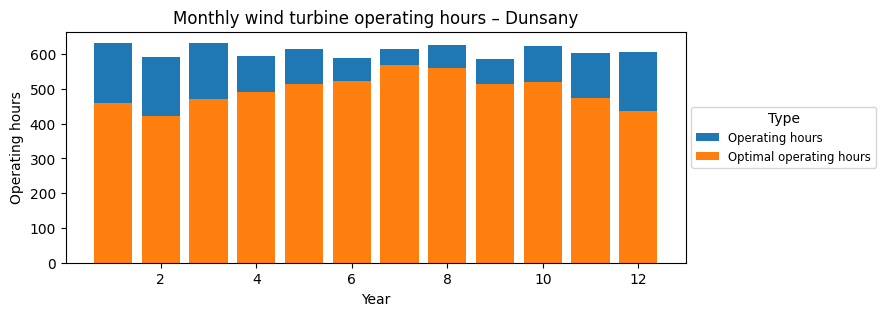

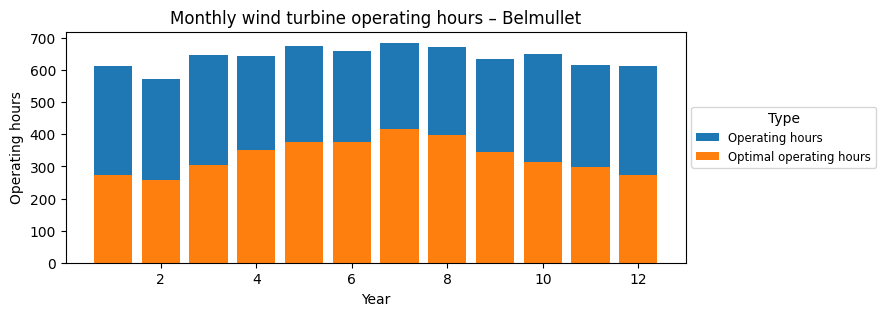

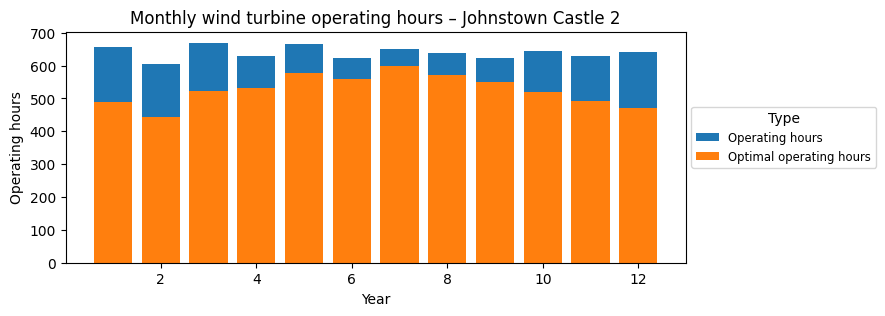

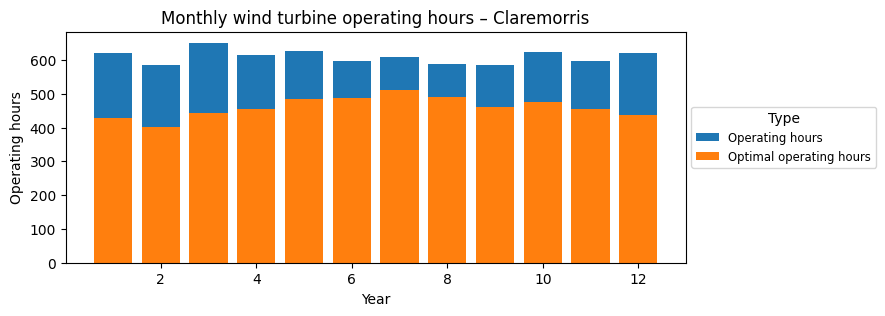

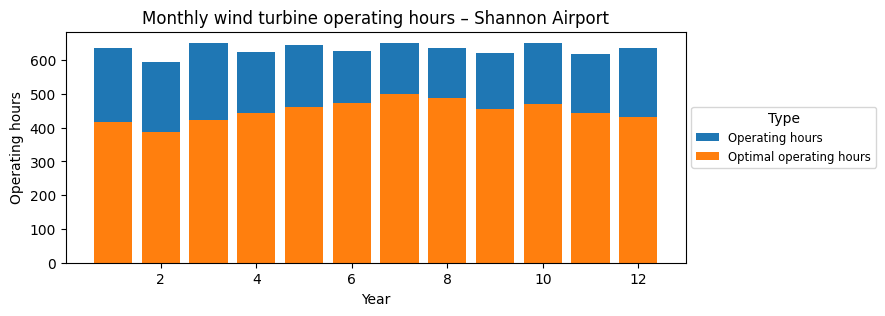

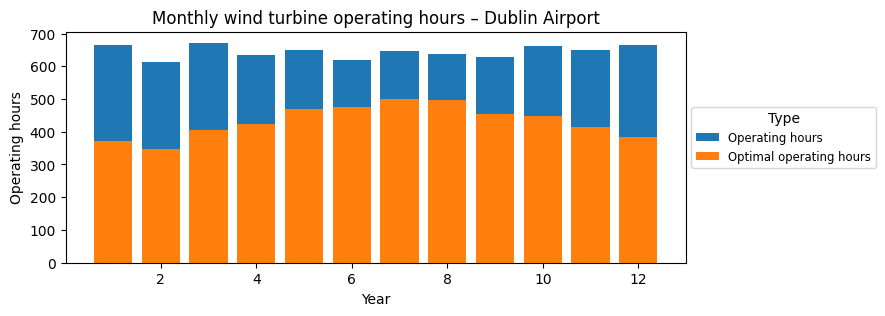

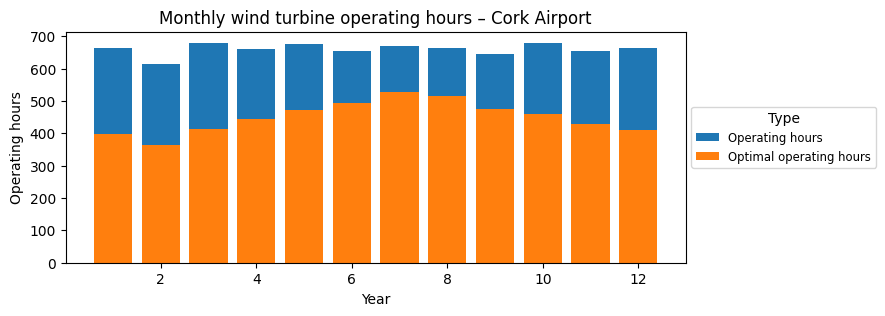

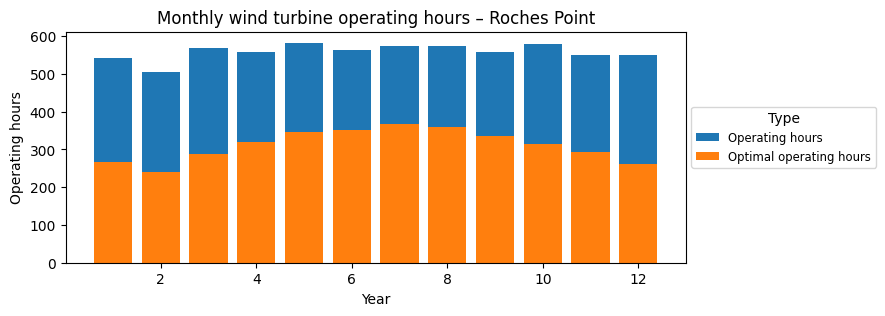

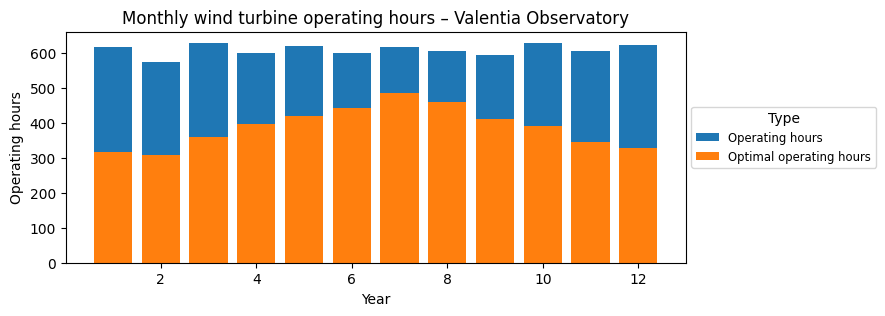

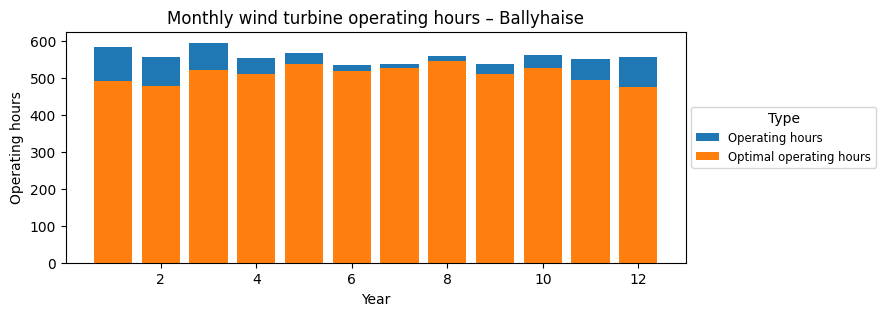

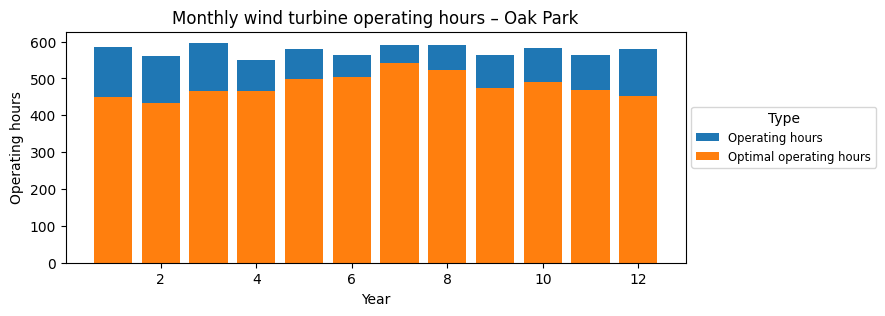

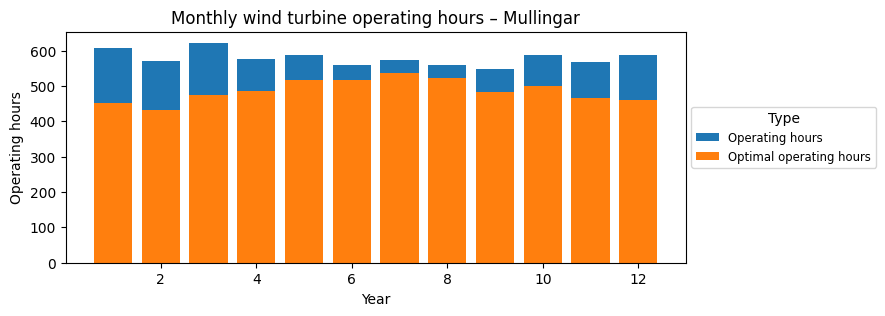

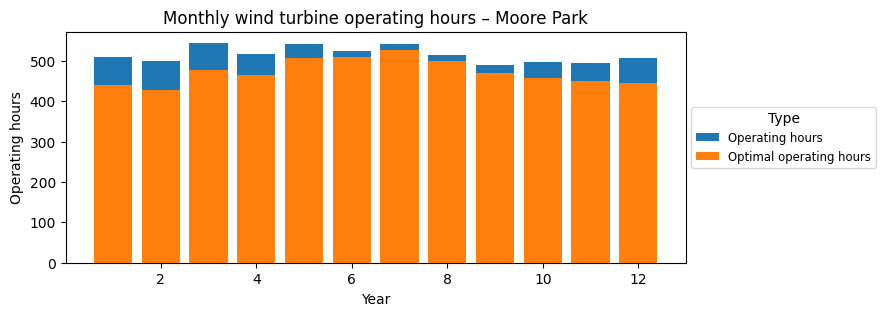

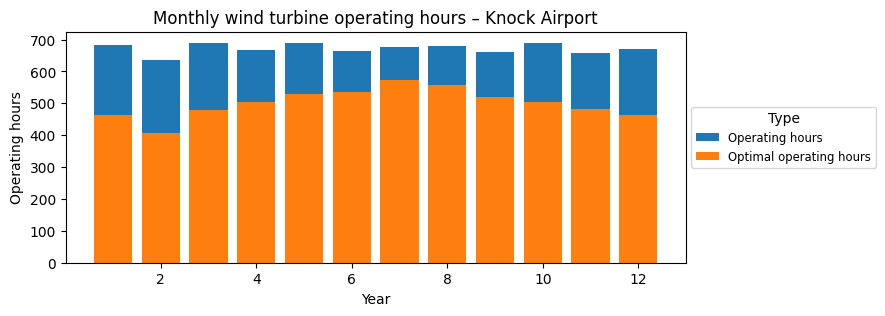

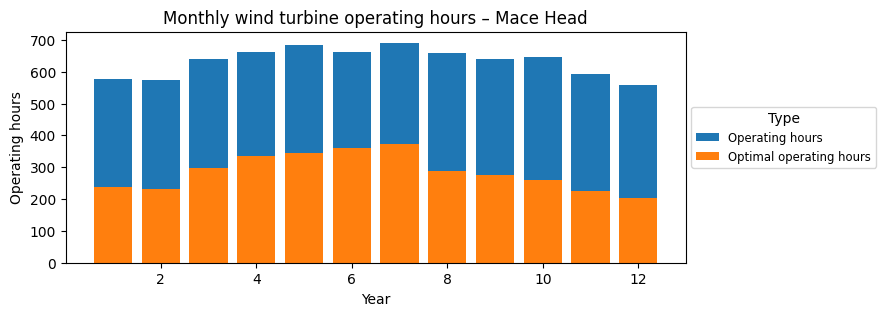

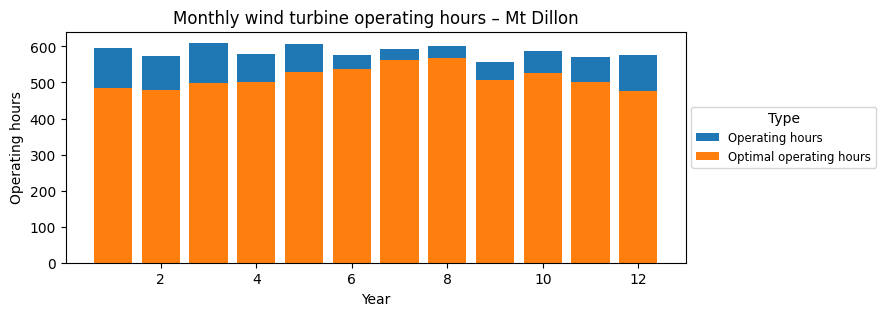

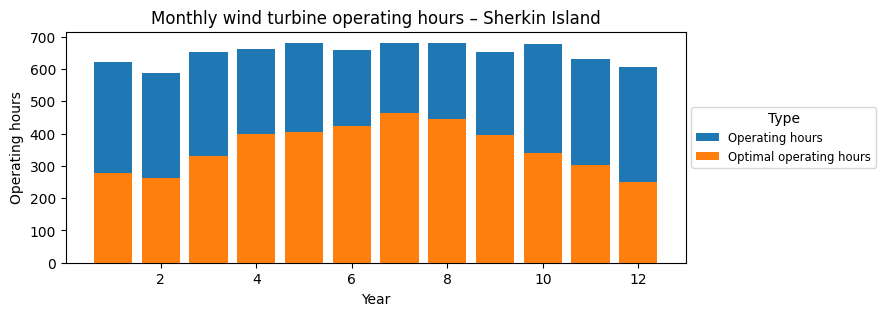

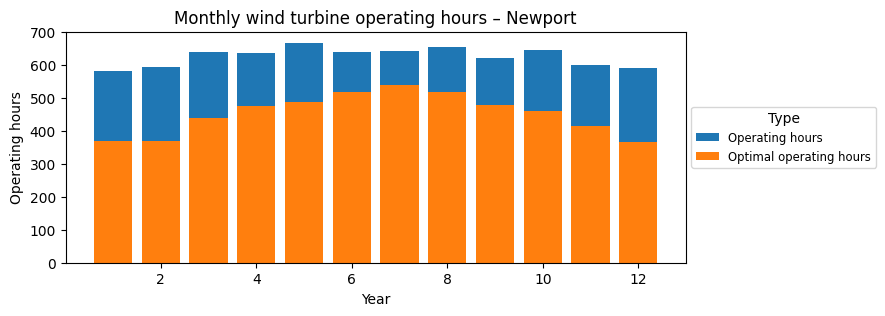

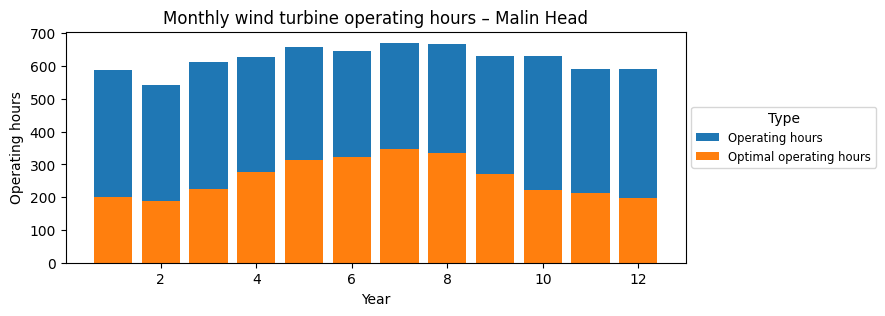

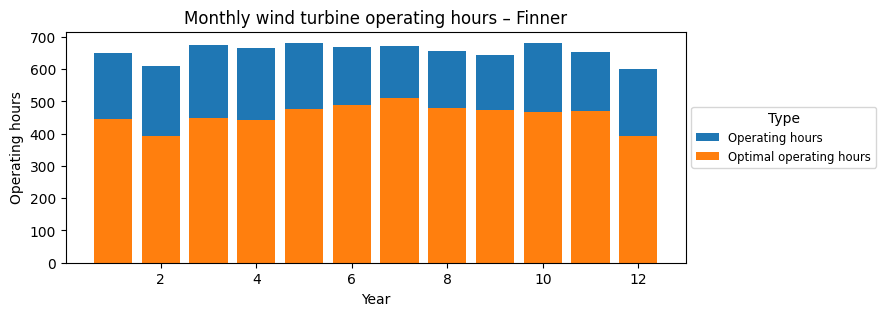

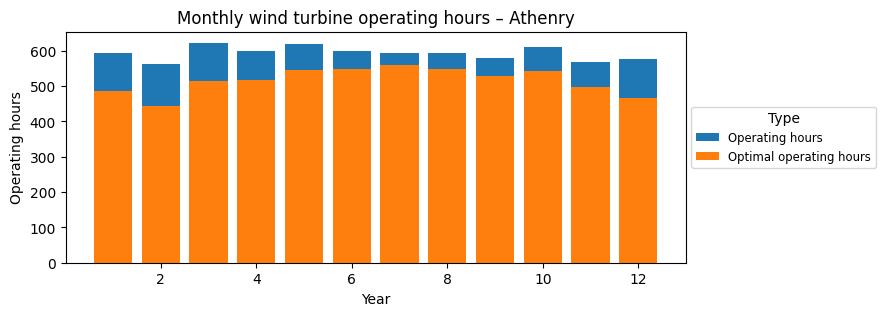

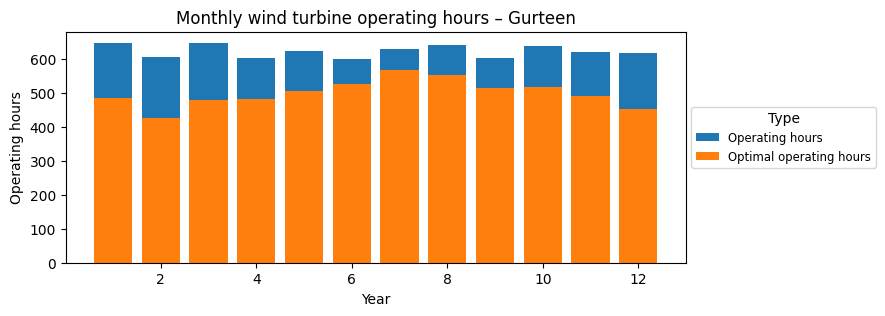

In [7]:
# Define the wind range
cut_in = 4
optimum = 12    
cut_out = 25

DATADIR = Path("stationdata")

for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file,low_memory=False)
    
    # Study wind range for wind turbines operation
    df["operating"] = (df["wdsp"] >= cut_in) & (df["wdsp"] <= cut_out)
    df["optimal"]   = (df["wdsp"] >= cut_in) & (df["wdsp"] <= optimum)

    # Number of hours of operation on average per month
    monthly_operating = (df.groupby(["year", "month"])["operating"].sum().groupby("month").mean())
    # Number of hours of optimal production on average per month
    monthly_optimal = (df.groupby(["year", "month"])["optimal"].sum().groupby("month").mean())


    # Number of hours of operation in total per month
    #monthly_operating = df.groupby("month")["operating"].sum().mean()
    # Number of hours of optimal production in total per month
    #monthly_optimal= df.groupby("month")["optimal"].sum().mean()

    fig, ax = plt.subplots(figsize=(8, 3))

    bars1 = ax.bar(monthly_operating.index, monthly_operating.values, label="Operating hours")

    bars2 = ax.bar(monthly_optimal.index, monthly_optimal.values, label="Optimal operating hours")

    station_name = file.stem.title()

    ax.set_xlabel("Year")
    ax.set_ylabel("Operating hours")
    ax.set_title(f"Monthly wind turbine operating hours – {station_name}")

    # value labels
    #ax.bar_label(bars1, fontsize=8, padding=3)
    #ax.bar_label(bars2, fontsize=8, padding=3)

    # legend
    ax.legend(title="Type", fontsize="small",bbox_to_anchor=(1,0.7))
    
    # put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
    plt.savefig(f"plot/Monthly operation hours - {station_name}.png")

plt.show()

## 5/ Study the wind speed trend

/tmp/ipykernel_47307/135519596.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(9,4))


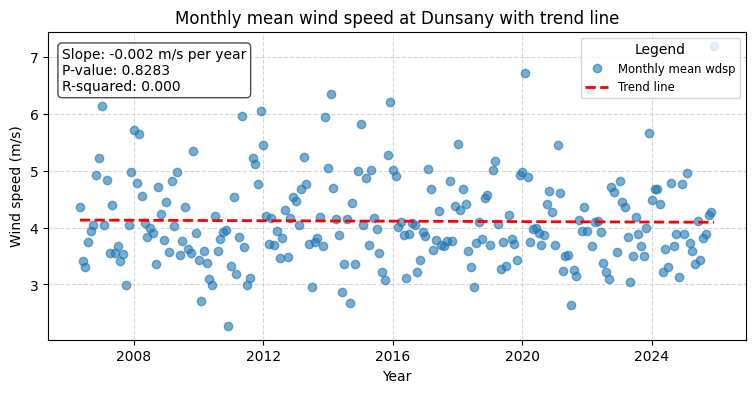

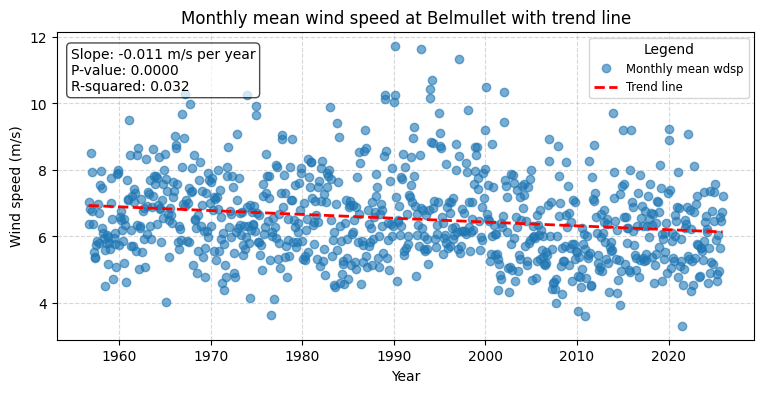

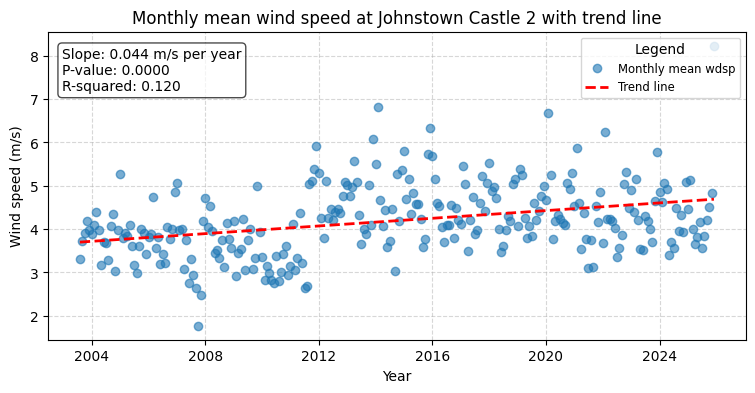

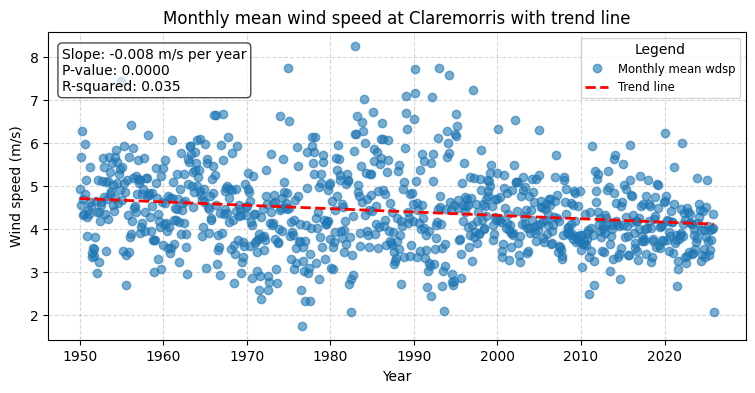

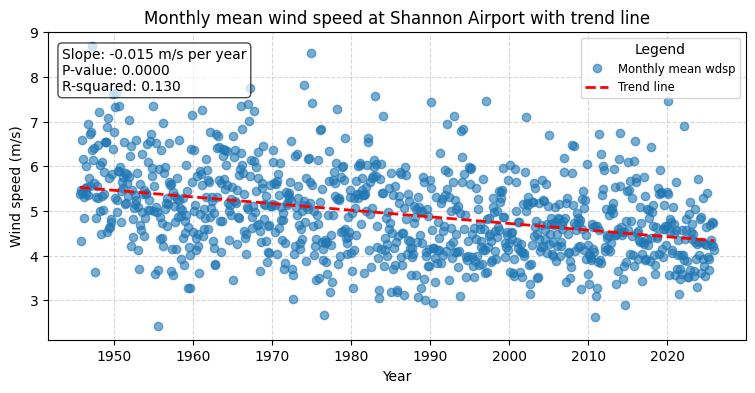

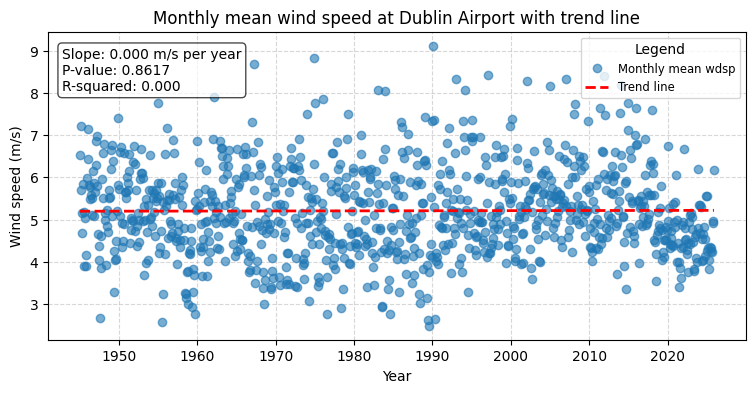

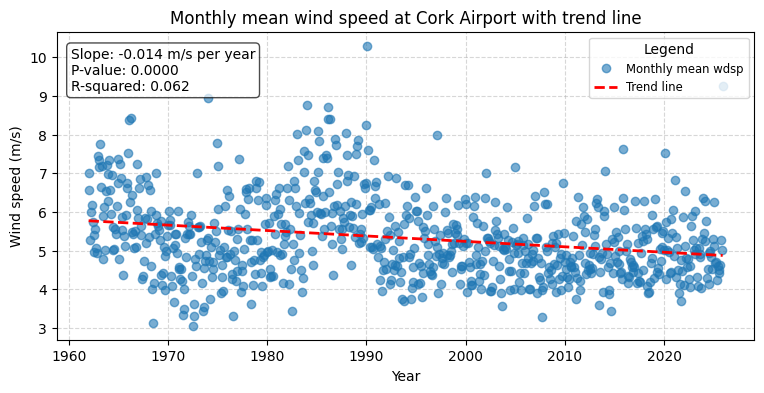

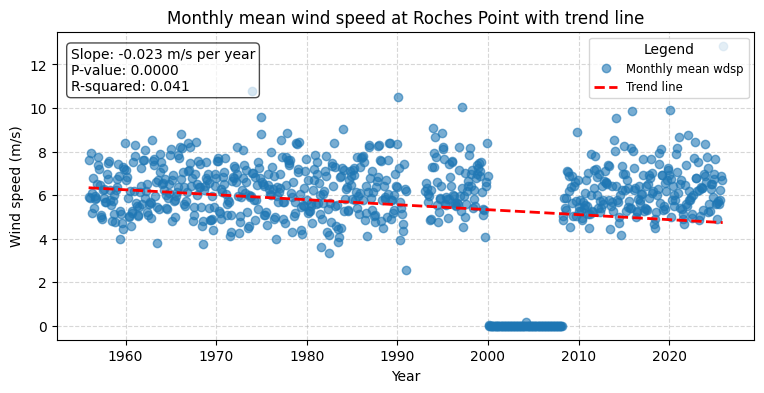

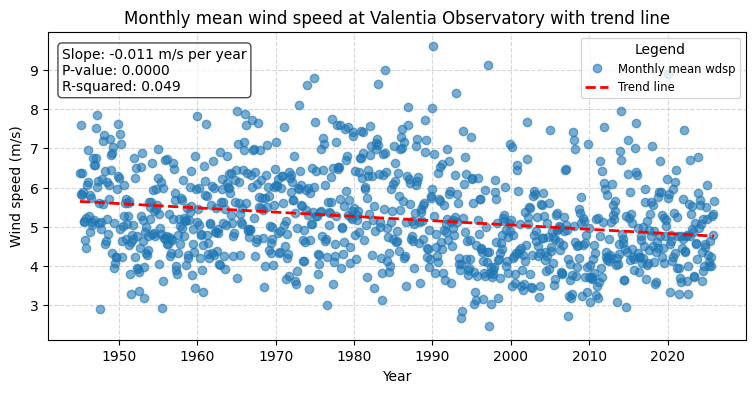

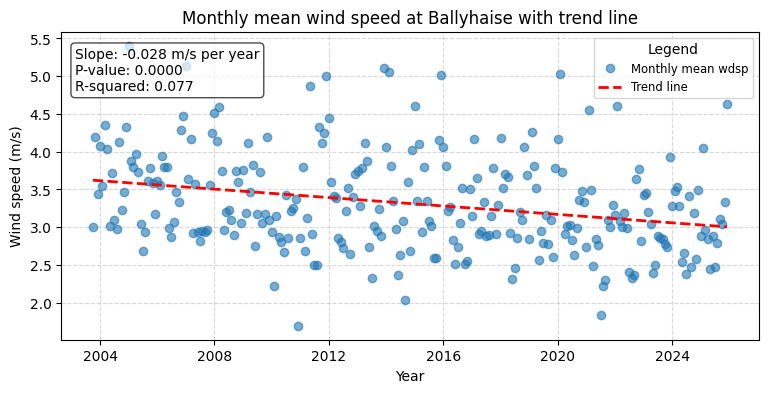

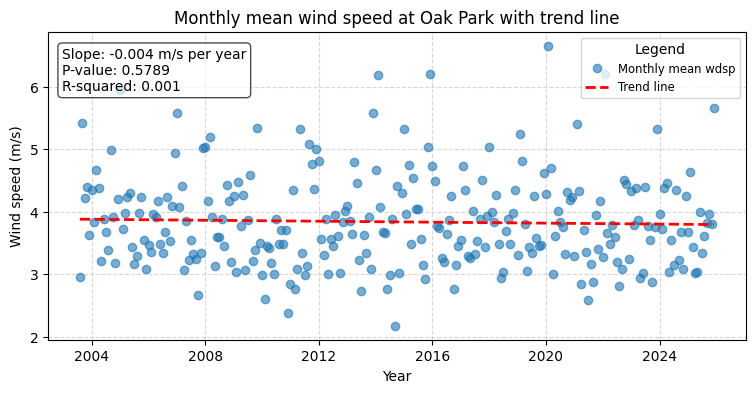

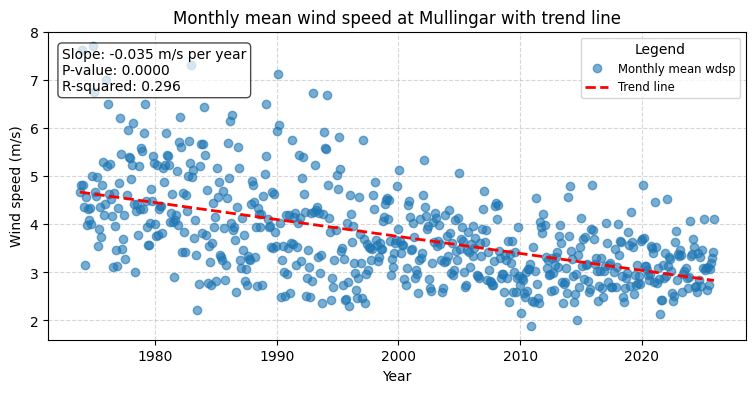

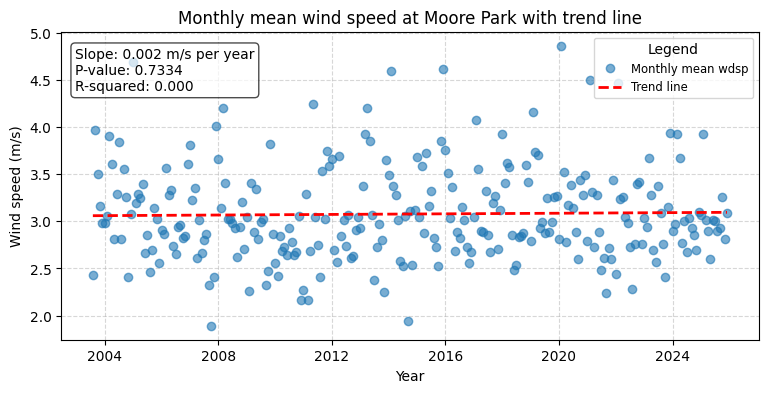

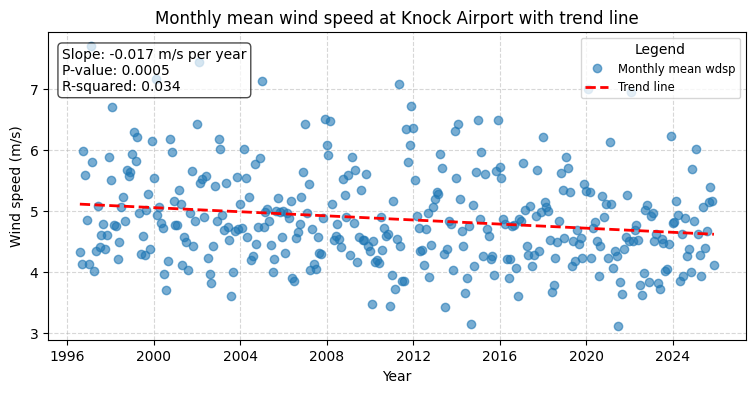

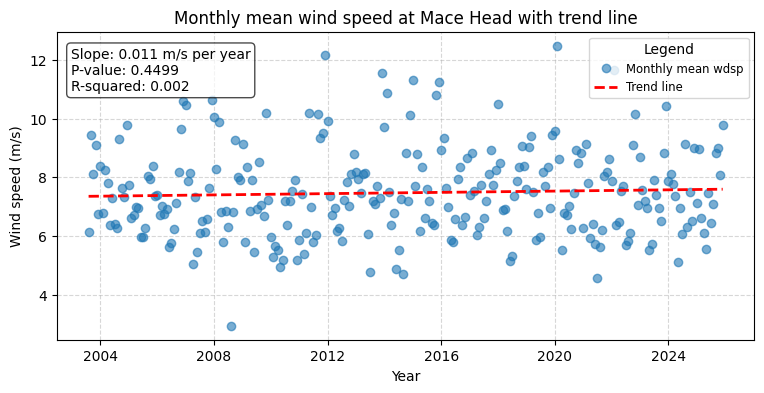

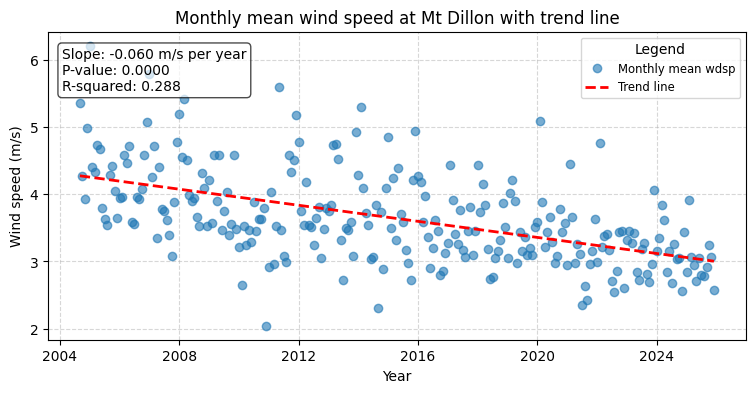

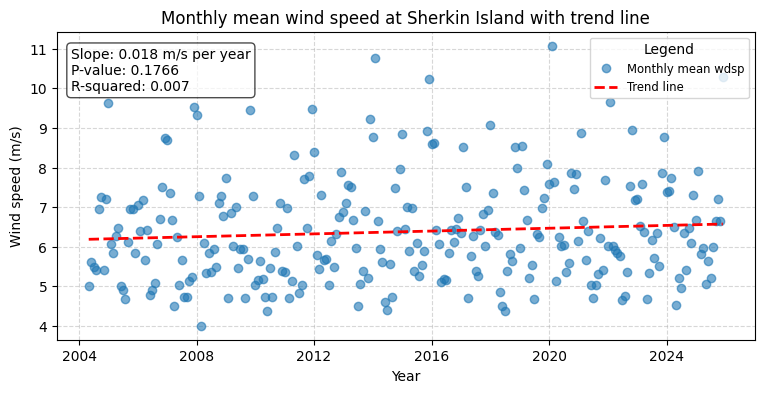

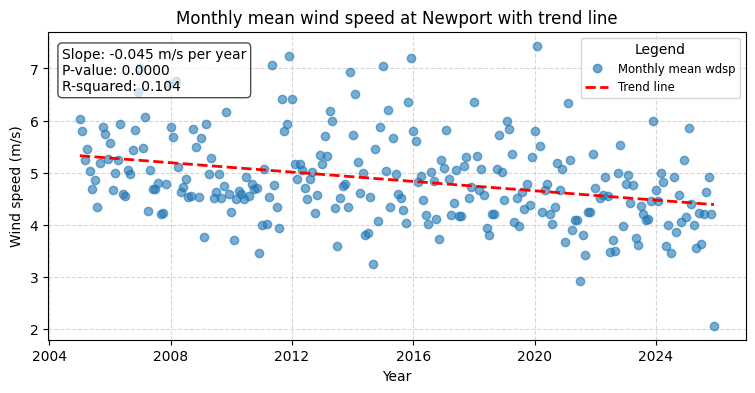

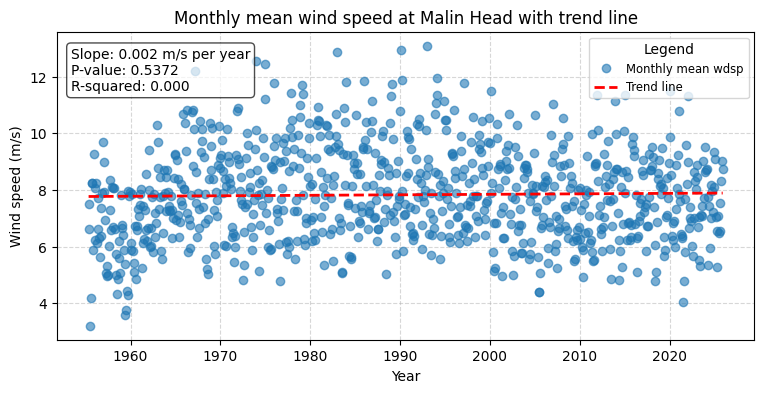

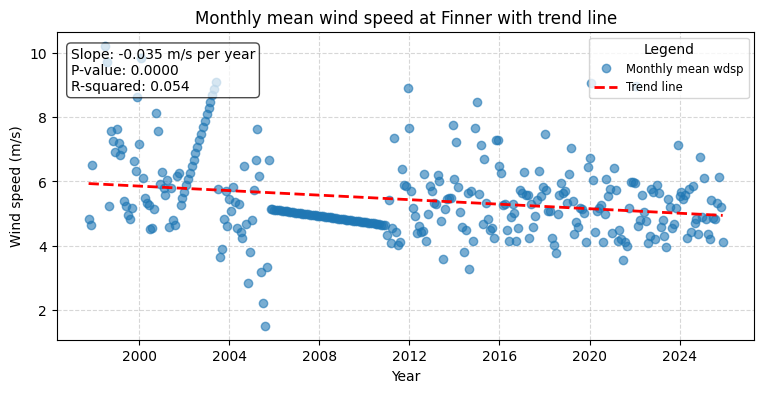

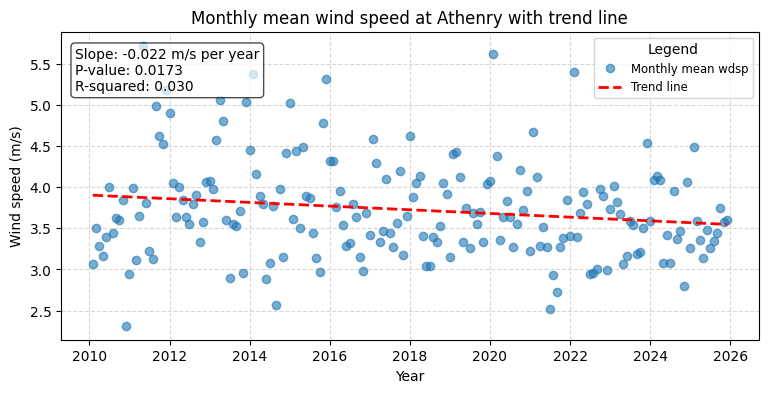

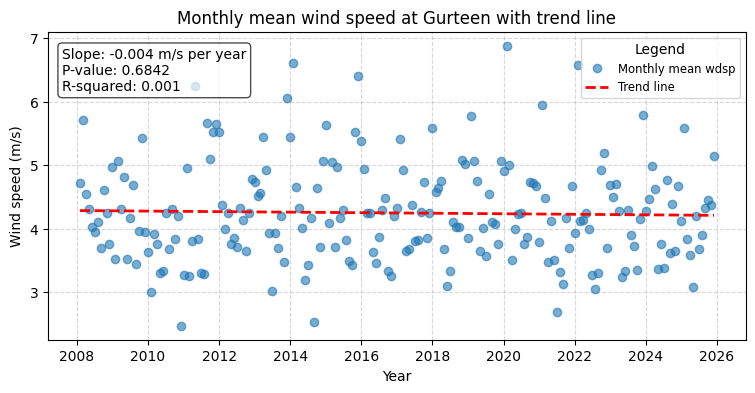

In [4]:
DATADIR = Path("stationdata")

# Read file
for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file,low_memory=False)

    # Calculate monthly mean wind speed 
    df["yearmonth"] = pd.to_datetime(df["yearmonth"], format="%Y-%m")
    monthly_mean = df.groupby("yearmonth")["wdsp_ms"].mean()

    # Convert datetime to numeric decimal years for regression
    X_numeric = monthly_mean.index.year + (monthly_mean.index.month - 1)/12
    Y = monthly_mean.values

    # Compute linear regression trend
    slope, intercept, r_value, p_value, std_err = linregress(X_numeric, Y)
    trend = intercept + slope * X_numeric

    #print(f"Slope: {slope:.3f} m/s per year")
    #print(f"P-value: {p_value:.4f}, R-squared: {r_value**2:.3f}")

    # Plot
    fig, ax = plt.subplots(figsize=(9,4))

    station_name = file.stem.title()

    # Monthly mean wind speed
    ax.plot(monthly_mean.index, Y, marker='o', linestyle='None', label="Monthly mean wdsp",alpha = 0.6)

    # Trend line
    ax.plot(monthly_mean.index, trend, linestyle='--', color='red', linewidth=2, label="Trend line")

    # Labels and title
    ax.set_xlabel("Year")
    ax.set_ylabel("Wind speed (m/s)")
    ax.set_title(f"Monthly mean wind speed at {station_name} with trend line")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title="Legend", fontsize='small',loc="upper right")

    # Add regression details on the plot
    ax.text(0.02, 0.95, f"Slope: {slope:.3f} m/s per year\nP-value: {p_value:.4f}\nR-squared: {r_value**2:.3f}", 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

# put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
#plt.savefig(f"plot/Trend study - monthly mean wind speed.png")

plt.show()

## Is there any other weather metric worth analyzing (eg rain, temp)

In [23]:
# convert 'wdsp' to numeric
df["rain"] = pd.to_numeric(df["rain"], errors="coerce")
corr_wdsp_rain = df["wdsp_ms"].corr(df["rain"])
# convert 'wdsp' to numeric
df["temp"] = pd.to_numeric(df["temp"], errors="coerce")
corr_wdsp_temp = df["wdsp_ms"].corr(df["temp"])

print(f"Correlation coefficient (wdsp_ms vs rain): {corr_wdsp_rain:}")
print(f"Correlation coefficient (wdsp_ms vs temp): {corr_wdsp_temp:}")


Correlation coefficient (wdsp_ms vs rain): 0.14252172403977037
Correlation coefficient (wdsp_ms vs temp): 0.15927152146487308


Wind speed shows a weak correlation with rainfall and temperature.

### try monthly correlation?

In [24]:
monthly = df.groupby("yearmonth")[["wdsp_ms", "rain", "temp"]].mean()

corr_month_wdsp_rain = monthly["wdsp_ms"].corr(monthly["rain"])
corr_month_wdsp_temp = monthly["wdsp_ms"].corr(monthly["temp"])

print(f"Monthly correlation coefficient (wdsp_ms vs rain): {corr_month_wdsp_rain:}")
print(f"Monthly correlation coefficient (wdsp_ms vs temp): {corr_month_wdsp_temp:}")

Monthly correlation coefficient (wdsp_ms vs rain): 0.5065504958709526
Monthly correlation coefficient (wdsp_ms vs temp): -0.379698449504856


Scatter plots show a moderate linear relationship between wind speed and rainfall, suggesting that windier periods often coincide with wetter conditions. Wind speed exhibits a moderate negative relationship with temperature, reflecting stronger winds during cooler conditions

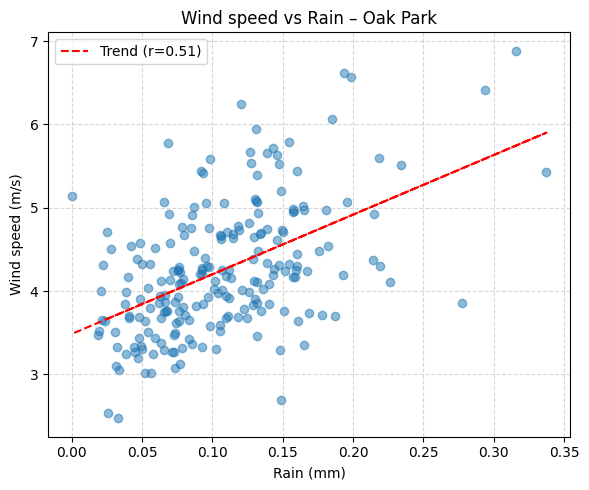

In [43]:
# Scatter plot
plt.figure(figsize=(6,5))
plt.scatter(monthly["rain"], monthly["wdsp_ms"], alpha=0.5)

# Trend line
slope, intercept, r_value, p_value, _ = linregress(monthly["rain"], monthly["wdsp_ms"])
trend = intercept + slope * monthly["rain"]

plt.plot(monthly["rain"], trend, color="red", linestyle="--",
         label=f"Trend (r={r_value:.2f})")

plt.xlabel("Rain (mm)")
plt.ylabel("Wind speed (m/s)")
plt.title("Wind speed vs Rain – Oak Park")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

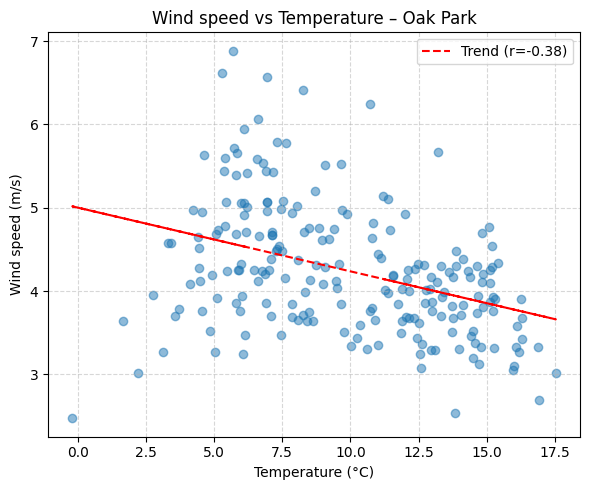

In [27]:
plt.figure(figsize=(6,5))
plt.scatter(monthly["temp"], monthly["wdsp_ms"], alpha=0.5)

# Trend line
slope, intercept, r_value, p_value, _ = linregress(monthly["temp"], monthly["wdsp_ms"])
trend = intercept + slope * monthly["temp"]

plt.plot(monthly["temp"], trend, color="red", linestyle="--",
         label=f"Trend (r={r_value:.2f})")

plt.xlabel("Temperature (°C)")
plt.ylabel("Wind speed (m/s)")
plt.title("Wind speed vs Temperature – Oak Park")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [44]:
DATADIR = Path("stationdata")

results = []

for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file)

    # convert 'wdsp' to numeric
    df["rain"] = pd.to_numeric(df["rain"], errors="coerce")

    # convert 'wdsp' to numeric
    df["temp"] = pd.to_numeric(df["temp"], errors="coerce")
    
    station = file.stem

    # Correlations
    monthly = df.groupby("yearmonth")[["wdsp_ms", "rain", "temp"]].mean()

    corr_month_wdsp_rain = monthly["wdsp_ms"].corr(monthly["rain"])
    corr_month_wdsp_temp = monthly["wdsp_ms"].corr(monthly["temp"])

    # Trend line
    slope_rain, intercept_rain, r_value_rain, p_value_rain, _ = linregress(monthly["rain"], monthly["wdsp_ms"])
    slope_temp, intercept_temp, r_value_temp, p_value_temp, _ = linregress(monthly["temp"], monthly["wdsp_ms"])

    results.append({
        "station": station,
        "wdsp_vs_rain": corr_month_wdsp_rain,
        "slope (rain x wdsp)": slope_rain,
        "intercept (rain x wdsp)": intercept_rain,
        "R-value (rain x wdsp)": r_value_rain,
        "P-value (rain x wdsp)": p_value_rain,
        "wdsp_vs_temp": corr_month_wdsp_temp,
        "intercept (temp x wdsp)": intercept_temp,
        "slope (temp x wdsp)": slope_temp,
        "R-value (temp x wdsp)": r_value_temp,
        "P-value (temp x wdsp)": p_value_temp,
    })

corr_df = pd.DataFrame(results)
corr_df["P-value (rain x wdsp)"] = corr_df["P-value (rain x wdsp)"].map("{:.3f}".format)
corr_df["P-value (temp x wdsp)"] = corr_df["P-value (temp x wdsp)"].map("{:.3f}".format)
corr_df

/tmp/ipykernel_4033/1051516127.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


/tmp/ipykernel_4033/1051516127.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/1051516127.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/1051516127.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/1051516127.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/1051516127.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/1051516127.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/10515161

station  wdsp_vs_rain  slope (rain x wdsp)  \
0                DUNSANY      0.431360             5.279019   
1              BELMULLET      0.559557            11.031462   
2     JOHNSTOWN CASTLE 2      0.435055             2.251646   
3            CLAREMORRIS      0.411710             5.661585   
4        SHANNON AIRPORT      0.281255             3.261536   
5         DUBLIN AIRPORT      0.203963             4.577393   
6           CORK AIRPORT      0.468827                  NaN   
7           ROCHES POINT      0.603536            19.946760   
8   VALENTIA OBSERVATORY      0.479859             5.554526   
9             BALLYHAISE      0.387834             3.237252   
10              OAK PARK      0.476128             6.301288   
11             MULLINGAR      0.312494             5.352287   
12            MOORE PARK      0.449736             3.316171   
13         KNOCK AIRPORT      0.536648             6.009418   
14             MACE HEAD      0.371316             4.358826   
15             MT DILLON      0.310790             3.479195   
16        SHERKIN ISLAND      0.602584            10.268589   
17               NEWPORT      0.522175             4.955488   
18            MALIN HEAD      0.506696            14.253665   
19                FINNER      0.484758                  NaN   
20               ATHENRY      0.211782             0.839806   
21               GURTEEN      0.506550             7.150225   

    intercept (rain x wdsp)  R-value (rain x wdsp) P-value (rain x wdsp)  \
0                  3.568693               0.431360                 0.000   
1                  5.018755               0.559557                 0.000   
2                  3.901299               0.435055                 0.000   
3                  3.640232               0.411710                 0.000   
4                  4.563383               0.281255                 0.000   
5                  4.810706               0.203963                 0.000   
6                       NaN                    NaN                   nan   
7                  3.556901               0.603536                 0.000   
8                  4.229928               0.479859                 0.000   
9                  2.925864               0.387834                 0.000   
10                 3.227740               0.476128                 0.000   
11                 3.153460               0.312494                 0.000   
12                 2.683197               0.449736                 0.000   
13                 3.922568               0.536648                 0.000   
14                 6.907312               0.371316                 0.000   
15                 3.204395               0.310790                 0.000   
16                 5.057151               0.602584                 0.000   
17                 3.918784               0.522175                 0.000   
18                 6.058722               0.506696                 0.000   
19                      NaN                    NaN                   nan   
20                 3.596710               0.211782                 0.003   
21                 3.487376               0.506550                 0.000   

    wdsp_vs_temp  intercept (temp x wdsp)  slope (temp x wdsp)  \
0      -0.403095                 4.900867            -0.080852   
1      -0.362708                 8.021673            -0.145891   
2      -0.383601                 5.132607            -0.089737   
3      -0.375596                 5.271654            -0.093585   
4      -0.321988                 5.777894            -0.081569   
5      -0.560803                 6.723995            -0.157232   
6      -0.517000                 6.790510            -0.151423   
7      -0.249729                      NaN                  NaN   
8      -0.506406                 7.295742            -0.191654   
9      -0.462204                 4.043610            -0.076666   
10     -0.288591                 4.379517            -0.053161   
11     -0.412630          

In [7]:
oakpark = pd.read_csv("stationdata/OAK PARK.csv")
oakpark.head()

/tmp/ipykernel_4033/4201213406.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  oakpark = pd.read_csv("stationdata/OAK PARK.csv")


date  wdsp  temp rain    dateonly  year yearmonth  month  \
0  2003-08-13 09:00:00   6.0  17.3  0.0  2003-08-13  2003   2003-08      8   
1  2003-08-13 10:00:00   6.0  18.5  0.0  2003-08-13  2003   2003-08      8   
2  2003-08-13 11:00:00   5.0  19.3  0.0  2003-08-13  2003   2003-08      8   
3  2003-08-13 12:00:00   5.0  20.4  0.0  2003-08-13  2003   2003-08      8   
4  2003-08-13 13:00:00   6.0  20.9  0.0  2003-08-13  2003   2003-08      8   

    hour   wdsp_ms   station       rho      power  
0  09:00  3.086667  OAK PARK  1.215312  17.870096  
1  10:00  3.086667  OAK PARK  1.210311  17.796569  
2  11:00  2.572222  OAK PARK  1.207000  10.270767  
3  12:00  2.572222  OAK PARK  1.202478  10.232281  
4  13:00  3.086667  OAK PARK  1.200433  17.651315

In [4]:
from pathlib import Path

data_dir = Path("stationdata")

for file in data_dir.glob("*.csv"):
    size_mb = file.stat().st_size / (1024*1024)
    print(f"{file.name} size: {size_mb:.2f} MB")

DUNSANY.csv size: 20.50 MB
BELMULLET.csv size: 74.07 MB
JOHNSTOWN CASTLE 2.csv size: 25.36 MB
CLAREMORRIS.csv size: 81.64 MB
SHANNON AIRPORT.csv size: 89.54 MB
DUBLIN AIRPORT.csv size: 88.19 MB
CORK AIRPORT.csv size: 68.79 MB
ROCHES POINT.csv size: 71.71 MB
VALENTIA OBSERVATORY.csv size: 93.57 MB
BALLYHAISE.csv size: 23.68 MB
OAK PARK.csv size: 23.48 MB
MULLINGAR.csv size: 55.10 MB
MOORE PARK.csv size: 23.82 MB
KNOCK AIRPORT.csv size: 32.26 MB
MACE HEAD.csv size: 23.91 MB
MT DILLON.csv size: 22.55 MB
SHERKIN ISLAND.csv size: 24.03 MB
NEWPORT.csv size: 21.88 MB
MALIN HEAD.csv size: 76.36 MB
FINNER.csv size: 29.30 MB
ATHENRY.csv size: 16.50 MB
GURTEEN.csv size: 18.68 MB


In [32]:
# change the type on 'wdsp' to numeric, the missing value will be turned into NaN with parameter errors="coerce"
df["wdsp"] = pd.to_numeric(df["wdsp"], errors="coerce")

# count the number of missing values
df["wdsp"].isna().sum()

np.int64(24)